## Classification of Hand Gestures

In this notebook, we train and evaluate different classification models for the task of hand gesture classification. We use the data generated in the previous notebook.

### Setup

---

To reload custom scripts automatically:

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define dependencies:

In [60]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import signal

# Modelling
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import os
import pickle
from tqdm import tqdm
import random
import sys
sys.path.insert(0, '../')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from src import utils

Define global variables:

In [61]:
DATA_ROOT = os.path.join("..", "data")
NINAPRO_ROOT = os.path.join("..", "data", "ninapro")
SAMPLING_EMG_RATE = 100

### Load the data preprocessed in the previous notebook

---

Before loading the data, make sure you downloaded them ([link](https://drive.google.com/file/d/1tz8tb6rruNvnlBkwDc80aT7D8jAXvwkF/view?usp=sharing)) and placed them into the data folder! 

We start by loading the data preprocessed in the previous notebook.

In [62]:
with open(os.path.join(DATA_ROOT, "exercise_1_processed.pkl"), 'rb') as file:
    subjects_features = pickle.load(file)

print("✅ Successfully loaded data, there are {} subjects.".format(len(subjects_features)))

✅ Successfully loaded data, there are 27 subjects.


Now, let's check what we get for instance for first subject:

In [63]:
# Get the data for the first subject
X_train, y_train, X_val, y_val, X_test, y_test = subjects_features[1]

# Print the shapes of the data
print(f"ℹ️ Number of windows: {X_train.shape[0]} (train), {X_val.shape[0]} (val), {X_test.shape[0]} (test)")
print(f"ℹ️ All have {X_train.shape[1]} features.")

ℹ️ Number of windows: 10143 (train), 5984 (val), 3977 (test)
ℹ️ All have 120 features.


<AxesSubplot:>

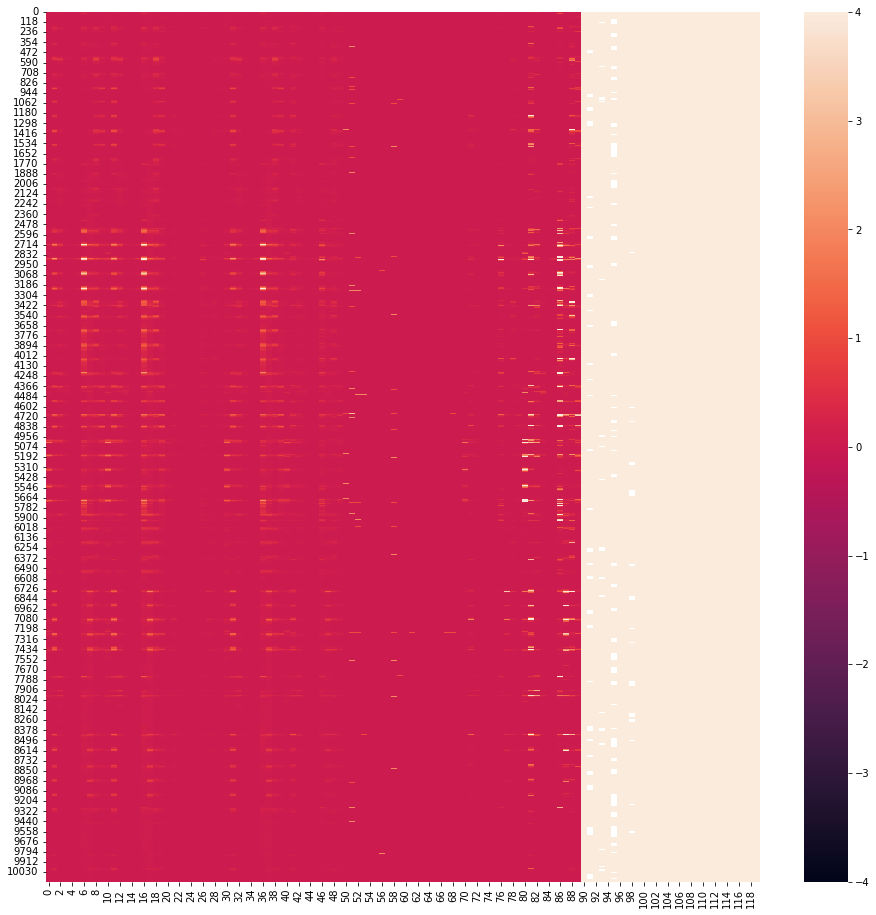

In [64]:
# Lets plot the features
fig,ax = plt.subplots(1,1,figsize = (16,16))
sns.heatmap(X_train[:,:],ax=ax, vmin = -4, vmax = 4)

<AxesSubplot:>

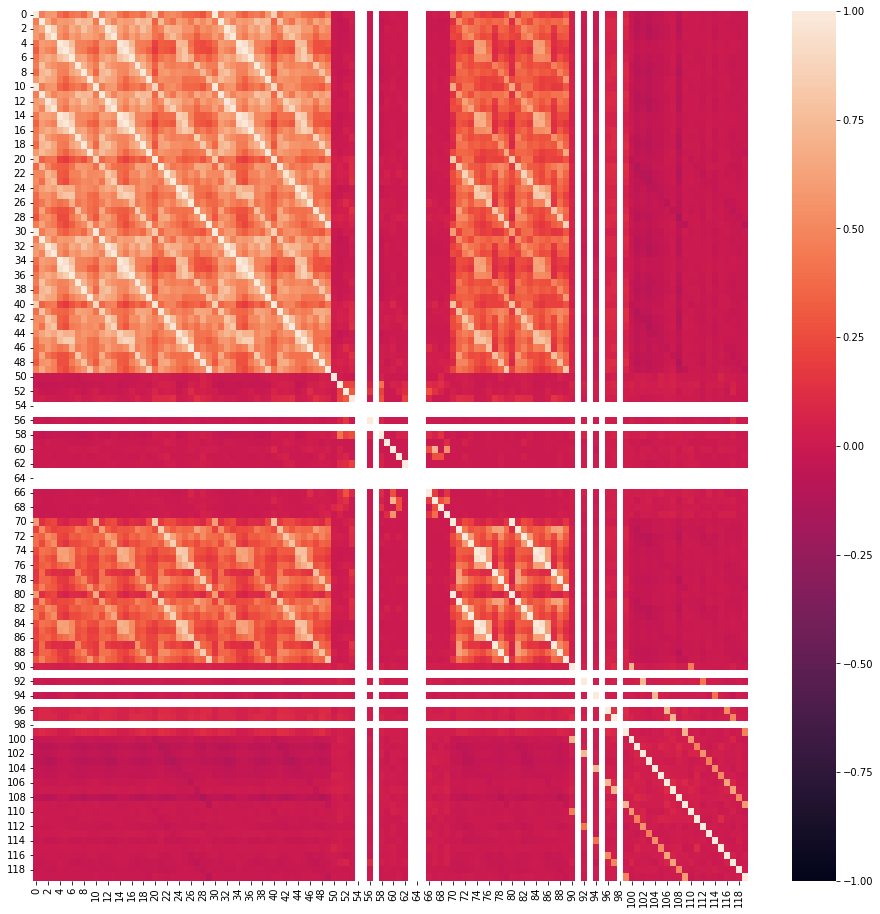

In [65]:
fig,ax = plt.subplots(1,1,figsize = (16,16))
sns.heatmap(np.corrcoef(X_train[:,:].T),ax=ax, vmin = -1, vmax = 1)

### PCA

In [66]:
from sklearn.decomposition import PCA

In [67]:
def reduce_dimensionality(trainingset, validationset ,testset, threshold_variance=0.95):
    """
    This function reduces the dimensionality of a dataset according to the optimal number of principal components obtained from PCA.

    Args:
        data: numpy array. Dataset.
        threshold_variance: float between 0 and 1. The percentage of information that should contain in the optimal number of principal components.

    Returns:
        reduced_data: numpy array. Dataset with reduced dimensionality.
    """

    # Ensure data is a 2D array
    if len(trainingset.shape) == 1:
        trainingset = trainingset.reshape(-1, 1)

    pca = PCA()
    pca.fit(trainingset)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    # Plot the explained variance
    plt.plot(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul, marker='o', linestyle='-', color='b')
    plt.title('Explained Variance per Principal Component')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')

    # Set x-axis ticks to integers
    plt.xticks(np.arange(1, len(exp_var_cumul) + 1, 1))

    plt.show()

    # Determine the optimal number of components based on a threshold (e.g., 95% variance)
    optimal_components = next((i for i, value in enumerate(exp_var_cumul) if value >= threshold_variance), len(exp_var_cumul))

    if optimal_components is not None:
        optimal_components += 1  # Add 1 to convert from zero-based index to the actual count
        print(f"The optimal number of components for {threshold_variance * 100}% variance retention is: {optimal_components}")

        # Reduce dimensionality
        pca.n_components = optimal_components
        reduced_trainingset = pca.transform(trainingset)
        reduced_validationset = pca.transform(validationset)
        reduced_testset = pca.transform(testset)
        

        return reduced_trainingset [:, :optimal_components], reduced_validationset[:, :optimal_components] ,reduced_testset[:, :optimal_components]
    
    else:
        print(f"No suitable number of components found for {threshold_variance * 100}% variance retention.")
        return np.array([]), np.array([]),

In [68]:
# Create a boolean mask for NaN values
mask_train = np.isnan(X_train)
mask_val = np.isnan(X_val)
mask_test = np.isnan(X_test)

# the mask filter the array and remove NaN values
X_train_without_nan = X_train[~mask_train]
X_val_without_nan = X_val[~mask_val]
X_test_without_nan = X_test[~mask_test]

# np.nan_to_num to replace NaN with a specific value
X_train_no_nan = np.nan_to_num(X_train, nan=0.0)
X_val_no_nan = np.nan_to_num(X_val, nan=0.0)
X_test_no_nan = np.nan_to_num(X_test, nan=0.0)


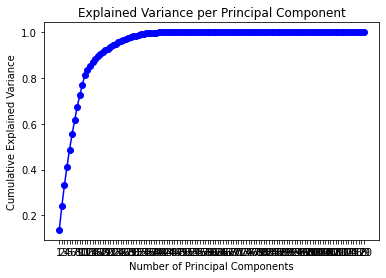

The optimal number of components for 95.0% variance retention is: 24


In [69]:
X_train_reduced, X_val_reduced, X_test_reduced = reduce_dimensionality(X_train_no_nan, X_val_no_nan, X_test_no_nan)

### Train and Eval the Models (One Subject)

---

In this section, we try to train and then evaluate the model on the data from 10 subjects. Note that these subjeocts will remain same for training as well as validation. We will train separate models for each subject and then evaluate them on the test data of the same subject.

In [75]:
# Select randmly 10 subjects
selected_subjects = random.sample(list(subjects_features.keys()), 10)

# Collect the data for the selected subjects
selected = dict()
for subject in selected_subjects:
    # Get the data for the subject
    X_train_reduced, y_train, X_val_reduced, y_val, X_test_reduced, y_test = subjects_features[subject]

    # Impute the missing values for features
    X_train_reduced = utils.impute_missing_values(X_train_reduced)
    X_val_reduced = utils.impute_missing_values(X_val_reduced)
    X_test_reduced = utils.impute_missing_values(X_test_reduced)

    # Add the data to the dictionary
    selected[subject] = (X_train_reduced, y_train, X_val_reduced, y_val, X_test_reduced, y_test)

Next, we define our model and train it:

In [76]:
# Define the models storage for each subject
models = dict()

for subject in tqdm(selected.keys()):

    # Get the train data
    X_train_reduced, y_train, _, _, _, _ = selected[subject]

    # Define the pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),  
        ('logistic regression', SGDClassifier(loss="hinge", penalty="l2", max_iter=100))
    ])

    # Train the pipeline on the training data
    model.fit(X_train_reduced, y_train);

    # Add the model to the dictionary
    models[subject] = model

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Finally, we evaluate the model on the validation data:

In [77]:

for subject in tqdm(selected.keys()):

    # Get the data on which we want to evaluate the model
    X_train_reduced, y_train, X_val_reduced, y_val, _, _ = selected[subject]

    # Get the model
    model = models[subject]

    # Make predictions on the train and validation sets
    y_train_pred = model.predict(X_train_reduced)
    y_val_pred = model.predict(X_val_reduced)

    # Compute the accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Print the results
    print(f"ℹ️ Subject {subject} - Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

 80%|████████  | 8/10 [00:00<00:00, 33.19it/s]

ℹ️ Subject 17 - Train acc: 0.892, Val acc: 0.855
ℹ️ Subject 13 - Train acc: 0.848, Val acc: 0.791
ℹ️ Subject 15 - Train acc: 0.889, Val acc: 0.824
ℹ️ Subject 1 - Train acc: 0.853, Val acc: 0.840
ℹ️ Subject 10 - Train acc: 0.822, Val acc: 0.787
ℹ️ Subject 20 - Train acc: 0.870, Val acc: 0.833
ℹ️ Subject 19 - Train acc: 0.823, Val acc: 0.752
ℹ️ Subject 9 - Train acc: 0.771, Val acc: 0.719


100%|██████████| 10/10 [00:00<00:00, 35.43it/s]

ℹ️ Subject 23 - Train acc: 0.801, Val acc: 0.741
ℹ️ Subject 6 - Train acc: 0.810, Val acc: 0.785


Accuracy of the classification: 0.7852205398288348


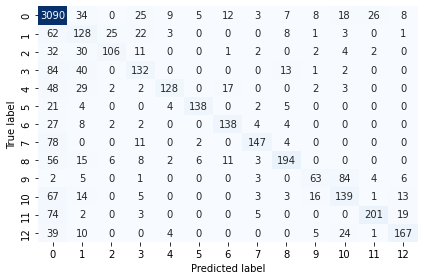

In [78]:
# We can use the metrics available in sklearn to evaluate the performance of the model.
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
y_true = y_val  # Replace [...] with your true labels
y_pred = y_val_pred  # Replace [...] with your predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy of the classification: {accuracy}")

# Calculate confusion matrix
confmat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()
plt.show()

---